<a href="https://colab.research.google.com/github/MichaelBieri/Sequence-Forecast-Energy-Values-Stock-Prices-using-Multivariate-Analysis/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mutli mit 30 Vorhersagen

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 2.6891 - val_loss: 2.2612
Epoch 2/50
1/1 [==============================] - 0s 126ms/step - loss: 2.2287 - val_loss: 1.8415
Epoch 3/50
1/1 [==============================] - 0s 205ms/step - loss: 1.8153 - val_loss: 1.4690
Epoch 4/50
1/1 [==============================] - 0s 120ms/step - loss: 1.4484 - val_loss: 1.1432
Epoch 5/50
1/1 [==============================] - 0s 132ms/step - loss: 1.1275 - val_loss: 0.8633
Epoch 6/50
1/1 [==============================] - 0s 194ms/step - loss: 0.8519 - val_loss: 0.6285
Epoch 7/50
1/1 [==============================] - 0s 138ms/step - loss: 0.6206 - val_loss: 0.4370
Epoch 8/50
1/1 [==============================] - 0s 104ms/step - loss: 0.4320 - val_loss: 0.2866
Epoch 9/50
1/1 [==============================] - 0s 148ms/step - loss: 0.2837 - val_loss: 0.1742
Epoch 10/50
1/1 [==============================] - 0s 93ms/step - loss: 0.1729 - val_loss: 0.0961
Epoch 11/50
1/1 [======

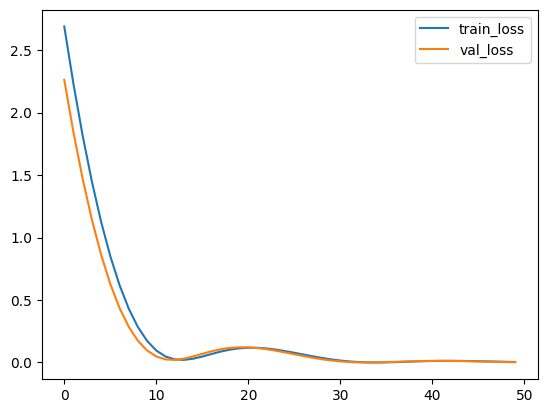

1/1 [==============================] - 0s 27ms/step - loss: 0.0026
Test Loss: 0.002574553247541189
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step
Next 30 Recursive Predictions:
Prediction 1: [25.37659     0.25045323]
Prediction 2: [25.380264    0.25043565]
Prediction 3: [25.379566    0.25036946]
Prediction 4: [25.378622    0.25029892]
Prediction 5: [25.37855    0.2502378]
Prediction 6: [25.379395   0.2501884]
Prediction 7: [25.380878   0.2501496]
Prediction 8: [25.382713    0.25011942]
Prediction 9: [25.384663  0.250096]
Prediction 10: [25.386566   0.2500778]
Prediction 11: [25.388327    0.25006366]
Prediction 12: [25.389896   0.2500526]
Prediction 13: [25.391258    0.25004405]
Prediction 14: [25.392418    0.25003734]
Prediction 15: [25.393393   0.2500321]
Prediction 16: [25.3942    0.250028]
Prediction 17: [25.394863    0.25002483]
Prediction 18: [25.395405    0.25002238]
Prediction 19: [25.395842   0.2500204]
Prediction 20: [25.396194    0.25001892]
Prediction 21: [25.396477    0.25001776]
Prediction 22: [25.396708    0.25001684]
Prediction 23: [25.396887    0.25001612]
Predi

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load data
file_path = 'merged_data2.csv'
data = pd.read_csv(file_path)

# Parse dates
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data = data.sort_values('Date')
data = data.fillna(method='ffill').fillna(method='bfill')  # Fill NaN values

# Define features and targets
features = [
    'electricity_price', 'global_economic_policy_uncertainty_index', 'sustainable_development_goals_index',
    'inflation', 'eu_inflation', 'hydropower', 'photovoltaic', 'wind', 'nuclear',
    'eu_gross_electricity_production', 'eu_electricity_price',
    'growth_nominal_gross_domestic_product', 'swiss_growth_in_real_gross_domestic_product',
    'grid_usage_price', 'energy_supply_costs', 'community_fees', 'feed_in_remuneration_at_cost_KEV',
    'swiss_environmental_performance_index'
]
targets = ['electricity_price', 'eu_electricity_price']

# Normalize data
scaler = MinMaxScaler()
data[features + targets] = scaler.fit_transform(data[features + targets])

# Create sequences
def create_sequences(data, features, targets, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        features_seq = data.iloc[i:i+window_size][features].values
        target_seq = data.iloc[i+window_size][targets].values
        sequences.append((features_seq, target_seq))
    return sequences

window_size = 38
sequences = create_sequences(data, features, targets, window_size)

# Split data into training and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Prepare data for the model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Ensure data types are consistent
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(window_size, len(features))))
model.add(Dense(len(targets)))

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Evaluate model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make initial predictions
initial_predictions = model.predict(X_test)

# Inverse transform the initial predictions
initial_predicted_values = np.hstack((X_test[:, -1, :], initial_predictions))
initial_predicted_values = scaler.inverse_transform(initial_predicted_values)

# Get the last window from the test set to start recursive prediction
last_window = X_test[-1]

# Recursive prediction for the next 30 values
recursive_predictions = []
current_window = last_window

for _ in range(30):
    next_prediction = model.predict(current_window[np.newaxis, :, :])
    combined_features_targets = np.hstack((current_window[-1, :], next_prediction[0]))
    next_prediction_scaled = scaler.inverse_transform(combined_features_targets.reshape(1, -1))[0]
    recursive_predictions.append(next_prediction_scaled[-len(targets):])

    # Update the window with the new prediction
    next_features = scaler.transform(next_prediction_scaled.reshape(1, -1))[0][:len(features)]
    current_window = np.vstack((current_window[1:], next_features))

# Print the next 30 predictions individually
print("Next 30 Recursive Predictions:")
for i, prediction in enumerate(recursive_predictions, 1):
    print(f"Prediction {i}: {prediction}")

# Mutiple target value

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.0711 - val_loss: 0.8009
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 0.7938 - val_loss: 0.5632
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 0.5599 - val_loss: 0.3695
Epoch 4/50
1/1 [==============================] - 0s 49ms/step - loss: 0.3689 - val_loss: 0.2189
Epoch 5/50
1/1 [==============================] - 0s 47ms/step - loss: 0.2200 - val_loss: 0.1100
Epoch 6/50
1/1 [==============================] - 0s 49ms/step - loss: 0.1118 - val_loss: 0.0404
Epoch 7/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0420 - val_loss: 0.0060
Epoch 8/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 9/50
1/1 [==============================] - 0s 101ms/step - loss: 8.7371e-04 - val_loss: 0.0180
Epoch 10/50
1/1 [==============================] - 0s 109ms/step - loss: 0.0162 - val_loss: 0.0464
Epoch 11/50
1/1 [========

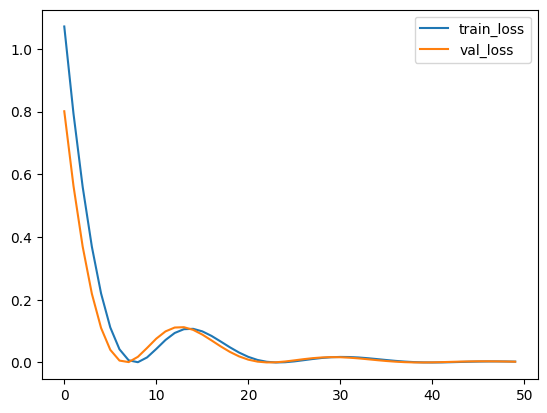

1/1 [==============================] - 0s 55ms/step - loss: 0.0025
Test Loss: 0.002463804092258215
1/1 [==============================] - 1s 672ms/step
[[26.359617    0.25442985]]


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load data
file_path = 'merged_data2.csv'
data = pd.read_csv(file_path)

# Parse dates
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data = data.sort_values('Date')
data = data.fillna(method='ffill').fillna(method='bfill')  # Fill NaN values

# Define features and targets
features = [
    'electricity_price', 'global_economic_policy_uncertainty_index', 'sustainable_development_goals_index',
    'inflation', 'eu_inflation', 'hydropower', 'photovoltaic', 'wind', 'nuclear',
    'eu_gross_electricity_production', 'eu_electricity_price',
    'growth_nominal_gross_domestic_product', 'swiss_growth_in_real_gross_domestic_product',
    'grid_usage_price', 'energy_supply_costs', 'community_fees', 'feed_in_remuneration_at_cost_KEV',
    'swiss_environmental_performance_index'
]
targets = ['electricity_price', 'eu_electricity_price']

# Normalize data
scaler = MinMaxScaler()
data[features + targets] = scaler.fit_transform(data[features + targets])

# Create sequences
def create_sequences(data, features, targets, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        features_seq = data.iloc[i:i+window_size][features].values
        target_seq = data.iloc[i+window_size][targets].values
        sequences.append((features_seq, target_seq))
    return sequences

window_size = 38
sequences = create_sequences(data, features, targets, window_size)

# Split data into training and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Prepare data for the model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Ensure data types are consistent
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(window_size, len(features))))
model.add(Dense(len(targets)))

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Evaluate model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predicted_values = np.hstack((X_test[:, -1, :], predictions))
predicted_values = scaler.inverse_transform(predicted_values)

# Display predictions
predicted_values = predicted_values[:, -len(targets):]
print(predicted_values)


# Single target prediction

    Unnamed: 0       Date  electricity_price  \
0            0 2014-01-01          17.282858   
1            1 2014-01-01          17.282858   
2            2 2015-01-01          18.428000   
3            3 2015-01-01          18.428000   
4            4 2015-01-01          18.428000   
5            5 2015-01-01          18.428000   
6            6 2015-01-01          18.428000   
7            7 2015-01-01          18.428000   
12          12 2016-01-01          18.252138   
11          11 2016-01-01          18.252138   
9            9 2016-01-01          18.252138   
8            8 2016-01-01          18.252138   
10          10 2016-01-01          18.252138   
13          13 2017-01-01          17.935080   
14          14 2017-01-01          17.935080   
18          18 2018-01-01          18.408220   
15          15 2018-01-01          18.408220   
16          16 2018-01-01          18.408220   
17          17 2018-01-01          18.408220   
21          21 2019-01-01          18.53

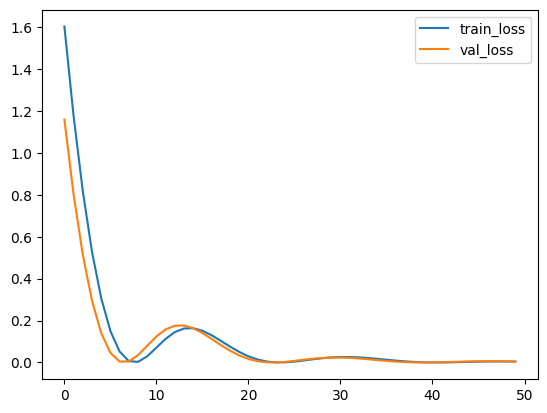

1/1 [==============================] - 0s 28ms/step - loss: 0.0046
Test Loss: 0.0045678275637328625


1/1 [==============================] - 1s 940ms/step
[33.3530552]


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'merged_data2.csv'
data = pd.read_csv(file_path)


# Parse dates
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data = data.sort_values('Date')
data = data.fillna(np.nan)
print(data)

# Select features and target
features = ['electricity_price', 'global_economic_policy_uncertainty_index',
            'sustainable_development_goals_index', 'inflation', 'eu_inflation',
            'hydropower', 'photovoltaic', 'wind', 'nuclear',
            'eu_gross_electricity_production', 'eu_electricity_price',
            'growth_nominal_gross_domestic_product', 'swiss_growth_in_real_gross_domestic_product',
            'grid_usage_price', 'community_fees', 'feed_in_remuneration_at_cost_KEV',
            'swiss_environmental_performance_index']
target = 'electricity_price'

# Normalize the data
scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Create sequences
def create_sequences(data, target, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        features_seq = data.iloc[i:i+window_size][features].values
        target_seq = data.iloc[i+window_size][target]
        sequences.append((features_seq, target_seq))
    return sequences

window_size = 38 # 38
sequences = create_sequences(data, target, window_size)

# Split the data into train and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Prepare the data for the model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Define the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(window_size, len(features))))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict the next values
predictions = model.predict(X_test)

# Inverse transform the predictions
predicted_energy_costs = scaler.inverse_transform(np.hstack((X_test[:, -1, :], predictions)))

# Display the predictions
predicted_energy_costs = predicted_energy_costs[:, -1]
print(predicted_energy_costs)

